Columnas detectadas en corr.fits: ['field_x', 'field_y', 'field_ra', 'field_dec', 'index_x', 'index_y', 'index_ra', 'index_dec', 'index_id', 'field_id', 'match_weight', 'ra_ref', 'dec_ref', 'mag', 'ref_cat', 'ref_id', 'pmra', 'pmdec', 'parallax', 'ra_ivar', 'dec_ivar', 'pmra_ivar', 'pmdec_ivar', 'parallax_ivar', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'FLUX', 'BACKGROUND']
Usando columnas: FLUX='FLUX', MAG='mag' 
Estrellas totales: 133  — válidas (flux>0 & finito): 133
ZP preliminar (sin clip): 20.8989 ± 0.1858 (N=133)
Vestigios: 8 outliers removidos por sigma-clipping (3σ).
ZP final (media sigma-clipped): 20.8788 ± 0.0955
ZP mediana (sigma-clipped): 20.8831
Tabla con ZP por estrella guardada en: /home/astrotomi/Downloads/corr_with_zp.csv


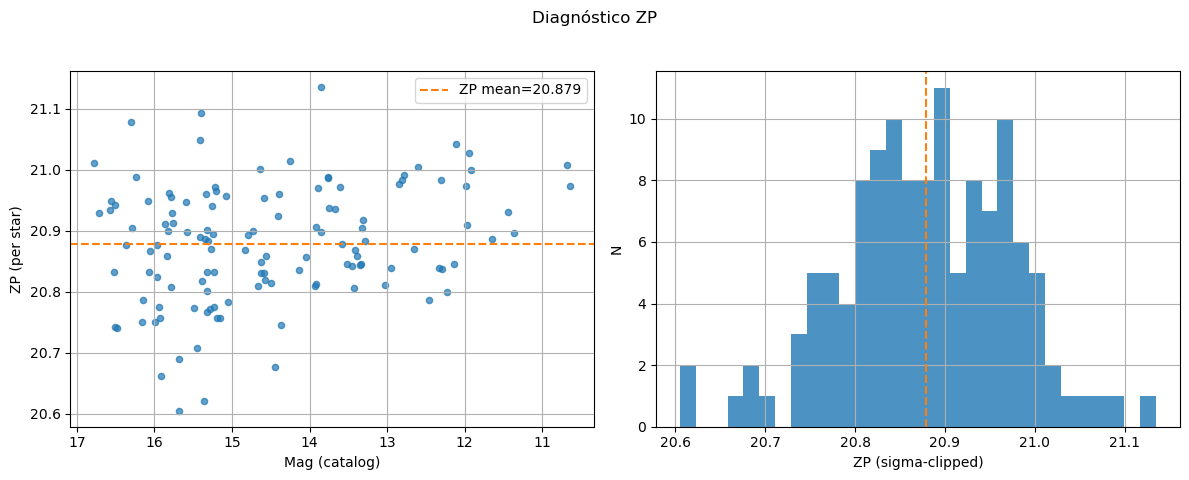

Gráfica diagnóstica guardada en: /home/astrotomi/Downloads/zp_diagnostics.png

--- RESUMEN FINAL ---
ZP a usar: 20.8788
Sigma de la muestra (post-clip): 0.0955
---------------------


In [1]:
# Código: calcular ZP por estrella desde /home/astrotomi/Downloads/corr.fits
# Requisitos: astropy, numpy, pandas, matplotlib, astropy.stats

from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
from pathlib import Path

# -------------------------
# Configuración
# -------------------------
fits_path = Path("/home/astrotomi/Downloads/corr.fits")
out_folder = fits_path.parent
csv_out = out_folder / "corr_with_zp.csv"
fig_out = out_folder / "zp_diagnostics.png"

# -------------------------
# Leer la tabla FITS (ext 1 ó 0 si es tabla en primary)
# -------------------------
with fits.open(fits_path) as hdul:
    # buscar extensión con tabla
    table_hdu = None
    for h in hdul:
        if hasattr(h, "data") and h.data is not None:
            # si es tabla (1D rows) o recarray
            table_hdu = h
            break
    if table_hdu is None:
        raise RuntimeError("No se encontró extensión con datos en el FITS.")
    data = table_hdu.data
    cols = table_hdu.columns.names
    print("Columnas detectadas en corr.fits:", cols)

# Convertir a DataFrame para comodidad
df = pd.DataFrame(np.array(data).byteswap().newbyteorder())  # evita issues de endianness

# -------------------------
# Buscar columnas FLUX y MAG (flexible, case-insensitive)
# -------------------------
col_candidates_flux = [c for c in df.columns if c.lower() in ("flux","flux_auto","flux_iso","flux_aper","fluxaper","flux_auto_1")]
col_candidates_mag  = [c for c in df.columns if c.lower() in ("mag","mag_cat","mag_catalog","mag_aper","mag_auto","mag_inst","magcal")]

# fallback: buscar substrings
if not col_candidates_flux:
    col_candidates_flux = [c for c in df.columns if "flux" in c.lower()]
if not col_candidates_mag:
    col_candidates_mag = [c for c in df.columns if "mag" in c.lower()]

if not col_candidates_flux:
    raise RuntimeError("No se encontró columna de FLUX en el FITS. Revisa nombres de columnas.")
if not col_candidates_mag:
    raise RuntimeError("No se encontró columna de MAG en el FITS. Revisa nombres de columnas.")

flux_col = col_candidates_flux[0]
mag_col  = col_candidates_mag[0]

# buscar posible columna de error de FLUX para un promedio ponderado
err_candidates = [c for c in df.columns if c.lower().startswith("fluxerr") or "flux_err" in c.lower() or c.lower().endswith("err")]
fluxerr_col = err_candidates[0] if err_candidates else None

print(f"Usando columnas: FLUX='{flux_col}', MAG='{mag_col}'", f", FLUXERR='{fluxerr_col}'" if fluxerr_col else "")

# -------------------------
# Preparar arrays y filtrado básico
# -------------------------
flux = np.array(df[flux_col], dtype=np.float64)
mag_cat = np.array(df[mag_col], dtype=np.float64)

# Filtrar valores inválidos
mask_valid = np.isfinite(flux) & np.isfinite(mag_cat) & (flux > 0)
n_before = len(flux)
n_valid = np.count_nonzero(mask_valid)
print(f"Estrellas totales: {n_before}  — válidas (flux>0 & finito): {n_valid}")

if n_valid == 0:
    raise RuntimeError("No hay entradas válidas (flux>0) para calcular ZP.")

flux = flux[mask_valid]
mag_cat = mag_cat[mask_valid]

if fluxerr_col:
    flux_err = np.array(df[fluxerr_col], dtype=np.float64)[mask_valid]
    # evitar ceros o negativos en errores
    flux_err = np.where((~np.isfinite(flux_err)) | (flux_err <= 0), np.nan, flux_err)
else:
    flux_err = None

# -------------------------
# Calcular ZP por estrella
# ZP_i = mag_catalog + 2.5 * log10(flux)
# -------------------------
zp_per_star = mag_cat + 2.5 * np.log10(flux)

# -------------------------
# Sigma clipping para eliminar outliers en ZP
# -------------------------
# primer estadístico bruto
zp_mean0 = np.nanmean(zp_per_star)
zp_std0 = np.nanstd(zp_per_star)
print(f"ZP preliminar (sin clip): {zp_mean0:.4f} ± {zp_std0:.4f} (N={len(zp_per_star)})")

# aplicar sigma-clip (3 sigma)
clipped = sigma_clip(zp_per_star, sigma=3.0, maxiters=5)
keep_mask = ~clipped.mask
print(f"Vestigios: {np.count_nonzero(~keep_mask)} outliers removidos por sigma-clipping (3σ).")

zp_clipped = zp_per_star[keep_mask]

# -------------------------
# Calcular promedio simple y promedio ponderado (si hay errores)
# -------------------------
zp_mean = np.mean(zp_clipped)
zp_median = np.median(zp_clipped)
zp_std = np.std(zp_clipped)

if flux_err is not None:
    # convertir errores de flujo a errores en magnitud: mag_err = 2.5 / ln(10) * (flux_err/flux)
    mag_err = (2.5 / np.log(10)) * (flux_err[keep_mask] / flux[keep_mask])
    # error in individual ZP_i is same as mag_err
    weights = 1.0 / (mag_err**2)
    zp_weighted = np.sum(zp_clipped * weights) / np.sum(weights)
    zp_weighted_err = np.sqrt(1.0 / np.sum(weights))
    print(f"ZP ponderado: {zp_weighted:.4f} ± {zp_weighted_err:.4f} (usando errores de flux)")
else:
    zp_weighted = None

print(f"ZP final (media sigma-clipped): {zp_mean:.4f} ± {zp_std:.4f}")
print(f"ZP mediana (sigma-clipped): {zp_median:.4f}")

# -------------------------
# Guardar tabla con ZP por estrella y FLAGS
# -------------------------
out_df = pd.DataFrame({
    "FLUX": flux,
    f"{mag_col}": mag_cat,
    "ZP_indiv": zp_per_star,
    "keep_sigma_clip": keep_mask
})

if flux_err is not None:
    out_df["FLUX_ERR"] = flux_err

out_df.to_csv(csv_out, index=False)
print(f"Tabla con ZP por estrella guardada en: {csv_out}")

# -------------------------
# Plots diagnósticos
# -------------------------
fig, axs = plt.subplots(1, 2, figsize=(12,5))

# 1) ZP vs MAG_catalog
axs[0].scatter(mag_cat[keep_mask], zp_clipped, s=20, alpha=0.7)
axs[0].axhline(zp_mean, color="C1", linestyle="--", label=f"ZP mean={zp_mean:.3f}")
if zp_weighted is not None:
    axs[0].axhline(zp_weighted, color="C2", linestyle="-.", label=f"ZP weighted={zp_weighted:.3f}")
axs[0].invert_xaxis()
axs[0].set_xlabel("Mag (catalog)")
axs[0].set_ylabel("ZP (per star)")
axs[0].legend()
axs[0].grid(True)

# 2) Histograma de ZP
axs[1].hist(zp_clipped, bins=30, alpha=0.8)
axs[1].axvline(zp_mean, color="C1", linestyle="--")
axs[1].set_xlabel("ZP (sigma-clipped)")
axs[1].set_ylabel("N")
axs[1].grid(True)

plt.suptitle("Diagnóstico ZP")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig(fig_out, dpi=200)
plt.show()
print(f"Gráfica diagnóstica guardada en: {fig_out}")

# -------------------------
# Resultado final que usaría en tu calibración
# -------------------------
# Recomendación: usar zp_weighted si existe, sino zp_mean (sigma-clipped).
zp_use = zp_weighted if zp_weighted is not None else zp_mean
print("\n--- RESUMEN FINAL ---")
print(f"ZP a usar: {zp_use:.4f}")
print(f"Sigma de la muestra (post-clip): {zp_std:.4f}")
print("---------------------")
